In [305]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
pd.options.mode.chained_assignment = None

In [433]:
nifty5 = pd.read_csv('NEW_Cleaned_Nifty50_5min.csv')
nifty5['EMA']=nifty5['Close'].ewm(span=5, adjust=False).mean()

In [589]:
daysconsidered=234 #offset to start for some given date
lastdateconsidered=0 #0 for 21st October 2022
years=[0, 234, 468, 702, 936, 1170, 1404]
#years=[234, 468, 702, 936, 1170, 1404]
b=nifty5.Date.nunique()-lastdateconsidered
a=b-daysconsidered

c1 = pd.DataFrame(columns=['Date', 'Number of trades','Average time','Balance'])
c1['Date'] = nifty5['Date']
c1['Number of trades']=0
c1['Average time']=0
c1['Balance']=0

c2 = pd.DataFrame(columns=['Date', 'Time','Balance','BoughtAt','SoldAt'])
c2['Date'] = nifty5['Date']
c2['Time'] = nifty5['Time']
c2['Balance'][a*75] = nifty5['Open'][a*75] 
c2['BoughtAt'] = 0
c2['SoldAt'] = 0
profp=[]
lossp=[]
th=[]

def buy(i,j,tgt,sl):
    global profp,lossp,th
    byp=nifty5['Close'][i*75+j]
    d=nifty5['Date'][i*75+j]
    k=j
    for k in range(j,70):
        if nifty5['Close'][i*75+k]<sl:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(byp-sl)/byp)
            th.append(k-j)
            return k, sl
        if nifty5['High'][i*75+k]>tgt:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Target hit!'.format(d,tgt,sl))
            profp.append(100*(tgt-byp)/byp)
            th.append(k-j)
            return k, tgt
    #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    th.append(k-j)
    return k, nifty5['Close'][i*75+k]

def sell(i,j,tgt,sl):
    global profp,lossp,th
    slp=nifty5['Close'][i*75+j]
    d=nifty5['Date'][i*75+j]
    k=j
    for k in range(j,70):
        if nifty5['Close'][i*75+k]>sl:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(sl-slp)/slp)
            th.append(k-j)
            return k, sl
        if nifty5['Low'][i*75+k]<tgt:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Target hit!'.format(d,tgt,sl))
            profp.append(100*(slp-tgt)/slp)
            th.append(k-j)
            return k, tgt
    #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    th.append(k-j)
    return k, nifty5['Close'][i*75+k]

proftolossratio=1.5
slippage=50 #in percentage terms

ini=nifty5['Open'][a*75]
balance=ini
minbalance=ini
maxbalance=0
tgt1=0
sl1=0
profit=0
leverage=1
sellflag=1
buyflag=1
slip=(1-slippage/100)
for i in range(a,b):
    profit=0
    #n=math.ceil(1,int(balance/nifty5['Open'][i*75]))
    k1=0
    if i>a:
        c2.at[i*75, 'Balance'] = c2.loc[i*75-1, 'Balance']
    for j in range(1,nifty5.Time.nunique()):
        if j<k1+1:
            continue  

        if j!=k1:
            c2.at[i*75+j, 'Balance'] = c2.loc[i*75+j-1, 'Balance']

        #print('Balance: {:.2f} at Time:{}'.format(c2.loc[i*75+j,'Balance'],c2.loc[i*75+j,'Time']))               
        if nifty5['Close'][i*75+j-1]>nifty5['EMA'][i*75+j-1] and sellflag==1 and nifty5['Open'][i*75+j-1]>nifty5['EMA'][i*75+j-1]:
            if nifty5['Close'][i*75+j]<nifty5['Open'][i*75+j]:
                if nifty5['Close'][i*75+j]<nifty5['EMA'][i*75+j]:
                    stpls=nifty5['High'][i*75+j-1]-nifty5['Close'][i*75+j]
                    trgt=nifty5['Close'][i*75+j]-stpls*proftolossratio
                    k1, byp=sell(i,j,trgt,nifty5['High'][i*75+j-1])       
                    profit=profit+(nifty5['Close'][i*75+j]-byp)*slip
                    for j1 in range(j,k1+1):
                        c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
                    c1.at[i*75, 'Number of trades']+=1
                    c2.at[i*75+k1, 'Balance'] = c2.loc[i*75+k1, 'Balance'] + (nifty5['Close'][i*75+j]-byp)*slip
                    c2.at[i*75+k1,'BoughtAt'] = byp
                    c2.at[i*75+j,'SoldAt'] = nifty5['Close'][i*75+j]
                    continue
                    #print('Sold and Bought with a profit of: {:.2f}'.format(nifty5['Close'][i*75+j]-byp))

        if nifty5['Close'][i*75+j-1]<nifty5['EMA'][i*75+j-1] and buyflag==1 and nifty5['Open'][i*75+j-1]<nifty5['EMA'][i*75+j-1]:
            if nifty5['Close'][i*75+j]>nifty5['Open'][i*75+j]:
                if nifty5['Close'][i*75+j]>nifty5['EMA'][i*75+j]:
                    stpls=0-nifty5['Low'][i*75+j-1]+nifty5['Close'][i*75+j]
                    trgt=nifty5['Close'][i*75+j]+stpls*proftolossratio
                    k1, slp=buy(i,j,trgt,nifty5['High'][i*75+j-1])       
                    profit=profit+(0-nifty5['Close'][i*75+j]+slp)*slip
                    for j1 in range(j,k1+1):
                        c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
                    c1.at[i*75, 'Number of trades']+=1
                    c2.at[i*75+k1, 'Balance'] = c2.loc[i*75+k1, 'Balance'] + (0-nifty5['Close'][i*75+j]+slp)*slip
                    c2.at[i*75+j,'BoughtAt'] = nifty5['Close'][i*75+j]
                    c2.at[i*75+k1,'SoldAt'] = slp
                    continue
#                     print(c2[['Time','Balance']][a*75:a*75+30])
#                     print('i:{} j:{} k:{}'.format(i,j,k1))
#                     print('Bought and Sold with a profit of: {:.2f} Current Balance: {:.2f}'.format(0-nifty5['Close'][i*75+j]+slp,c2.loc[i*75+k1,'Balance']))
#                     print('Bought and Sold at {:.2f} & {:.2f} respectively at time: {} and {}'.format(nifty5['Close'][i*75+j],slp,c2.loc[i*75+j,'Time'],c2.loc[i*75+k1,'Time']))

    th=np.array(th)
    c1.at[i*75, 'Average time'] = th.mean()*5
    th=[]
    balance=balance+leverage*profit
    c1.at[i*75, 'Balance'] = balance
    if balance<0:
        print("Total Loss")
        break
    if balance>=maxbalance:
        maxbalance=balance
    if balance<minbalance:
        minbalance=balance

res=(balance-ini)/ini
print('Total count of trade days :',len(c1[c1['Number of trades']!=0]),'out of ',b-a,' days')
print('Average number of trades per day: {:.2f}'.format(c1[c1['Number of trades']!=0]['Number of trades'].mean()))
print('Average time held per trade: {:.2f} minutes \n'.format(c1[c1['Number of trades']!=0]['Average time'].mean()))
irr=100*(pow(10,math.log(1+res,10)/(daysconsidered/234))-1)
if balance>=ini:
    print("Final Balance is ₹{:.2f} with return of {:.2f}% Annualized to {:.2f}%".format(balance,res*100,irr))
else:
    print("Final Balance is ₹{:.2f} with a loss of {:.2f} at -{:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))
ren=(nifty5['Close'][i*75+j]-nifty5['Close'][a*75+j])/nifty5['Close'][a*75+j]
irrn=100*(pow(10,math.log(1+ren,10)/(daysconsidered/234))-1)
print("Nifty Return for the same time period is {:.2f}% Annualized to {:.2f}%".format(100*ren,irrn))
profp=np.array(profp)
lossp=np.array(lossp)
pn=len(profp)
ln=len(lossp)
pm=profp.mean()
lm=lossp.mean()
print('\nNumber of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))
print('\nRESULTS WITH LEVERAGE OF 5x')
profp=profp*leverage
lossp=lossp*leverage
pm=profp.mean()
lm=lossp.mean()
print('Number of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))

Total count of trade days : 234 out of  234  days
Average number of trades per day: 5.79
Average time held per trade: 42.16 minutes 

Final Balance is ₹23171.70 with return of 26.05% Annualized to 26.05%
Minimum Balance was ₹18382.70 and Maximum Balance was ₹23171.70
Nifty Return for the same time period is -3.49% Annualized to -3.49%

Number of Profits: 442 Losses: 679 
Average Profit: 0.23% Average Loss: 0.08%
Win ratio of: 39.43% and net profit per trade of 0.04%

RESULTS WITH LEVERAGE OF 5x
Number of Profits: 442 Losses: 679 
Average Profit: 0.23% Average Loss: 0.08%
Win ratio of: 39.43% and net profit per trade of 0.04%


<Figure size 7200x4800 with 0 Axes>

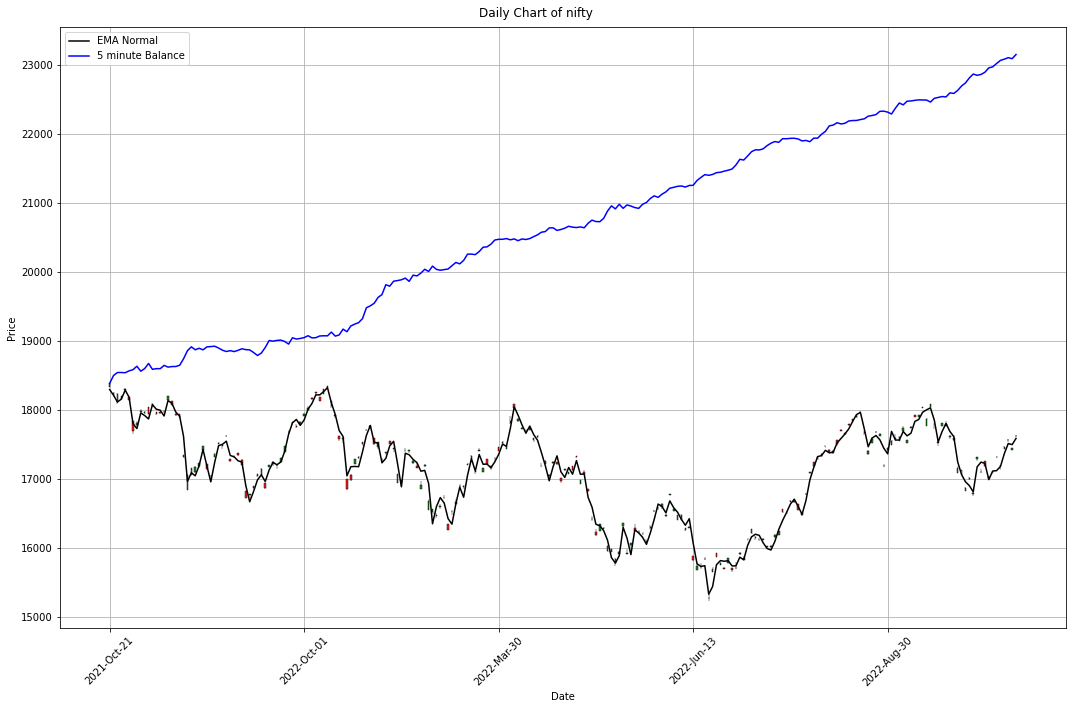

In [590]:
f=75
plotnifty=nifty5.iloc[a*75:b*75:f, :]
plotnifty.index= pd.to_datetime(plotnifty.Date)
plotnifty.drop('Date',axis=1,inplace=True)
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(15,10))
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values,'k',label='EMA Normal')
plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
#plt.plot(c2['BoughtAt'][a*75::f].values,'g^')
#plt.plot(c2['SoldAt'][a*75::f].values,'rv')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Daily Chart of nifty')
fig.tight_layout()
plt.grid()
plt.legend()
plt.savefig(nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])

In [591]:
c3 = pd.DataFrame(columns=['Date', 'Time','Nifty','Strat','NiftyR','StratR'])
c3['Date'] = nifty5.iloc[a*75::f, :]['Date']
c3['Time'] = nifty5.iloc[a*75::f, :]['Time']
c3['Nifty'] = nifty5.iloc[a*75::f, :]['Close']
c3['Strat'] = c2['Balance'][a*75::f].values
c3.reset_index(inplace=True)
c3.drop('index',axis=1,inplace=True)
c3.at[0,'NiftyR'] = 0
c3.at[0,'StratR'] = 0
for i in range(1,len(nifty5.iloc[a*75::f, :]['Close'])):
    c3.at[i,'NiftyR'] = 100*(c3.loc[i,'Nifty']-c3.loc[i-1,'Nifty'])/c3.loc[i,'Nifty']
    c3.at[i,'StratR'] = 100*(c3.loc[i,'Strat']-c3.loc[i-1,'Strat'])/c3.loc[i,'Strat']
print('Standard Deviation for Nifty: {:.3f} and for Strategy: {:.3f}'.format(c3['Nifty'].std(),c3['Strat'].std()))
print('Standard Deviation of Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c3['NiftyR'].std(),c3['StratR'].std()))
#print('Average Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c3['NiftyR'].mean(),c3['StratR'].mean()))

Standard Deviation for Nifty: 682.682 and for Strategy: 1395.429
Standard Deviation of Daily Returns for Nifty: 1.246% and for Strategy: 0.189%


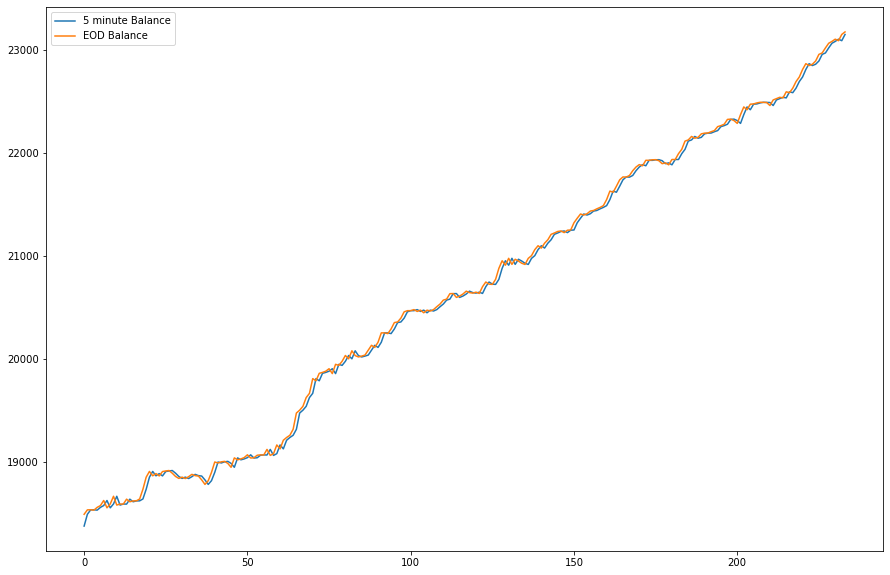

In [592]:
fig, ax = plt.subplots(figsize=(15,10))
plotc1 = c1.drop_duplicates('Date')
plotc1=plotc1[a:b]
plotc2=c2['Balance'][a*75:b*75:75].values
plotc1['Balance'] = plotc1['Balance']
plotc2=np.array(plotc2)
plt.plot(plotc2,label='5 minute Balance')
plt.plot(plotc1['Balance'].values,label='EOD Balance')
plt.legend()

-20.465811965796387


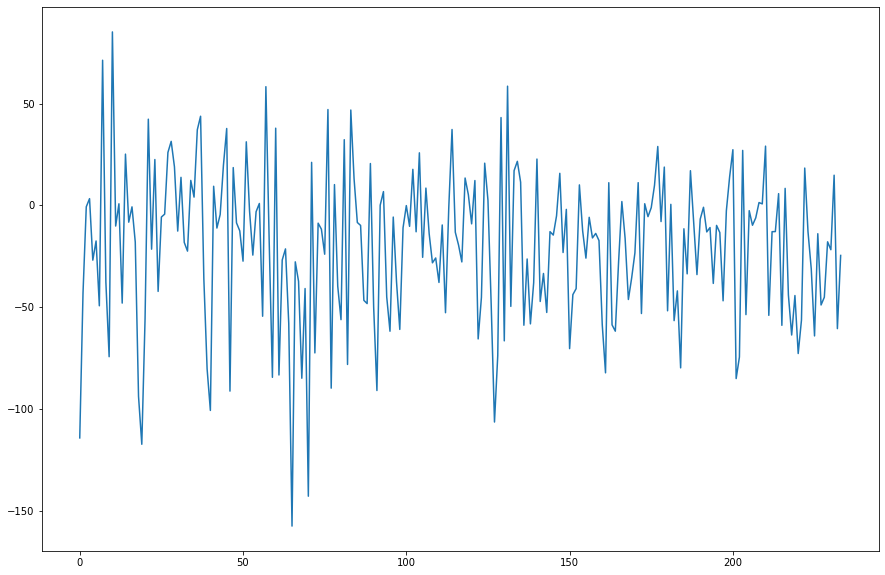

In [593]:
fig, ax = plt.subplots(figsize=(15,10))
x=np.array(plotc2-plotc1['Balance'].values)
plt.plot(x)
print(x.mean())